## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List
import warnings

warnings.filterwarnings('ignore')

# Set style for thesis-quality figures
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Set color palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

In [2]:
# Paths
DATA_DIR = Path(r"d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data")
OUTPUT_DIR = DATA_DIR / 'rq1_analysis'
FIGURES_DIR = OUTPUT_DIR / 'figures'

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Input file
EVALUATION_BASE = DATA_DIR / 'evaluation_base.csv'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Input file: {EVALUATION_BASE}")

Data directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data
Output directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis
Figures directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures
Input file: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\evaluation_base.csv


## Load Data

### Important: Understanding Vulnerability Counts

The dataset contains two types of vulnerability counts:

**1. Total Counts** (includes duplicates):
- `total_vulnerabilities_identified`: All vulnerability occurrences (same CWE detected by multiple tools = counted multiple times)
- `total_vulnerabilities_fixed`: All fixed occurrences
- `total_vulnerabilities_remaining`: All remaining occurrences

**2. Unique CWE Counts** (no duplicates):
- `unique_cwes_identified`: Distinct CWE types found (same CWE detected by multiple tools = counted once)
- `unique_cwes_fixed`: Distinct CWE types fixed
- `unique_cwes_remaining`: Distinct CWE types remaining

**Which to use?**
- **For tool comparison & overlap analysis**: Use total counts to see all detections
- **For fix effectiveness & fix provider analysis**: Use unique counts (aligns with `fix_provider_llm` and `fix_provider_rule_based`)
- **For reporting distinct vulnerability types**: Use unique counts

**Note**: `fix_provider_llm` + `fix_provider_rule_based` + `fix_provider_unknown` = `unique_cwes_fixed` (NOT `total_vulnerabilities_fixed`)

In [3]:
# Load evaluation base dataset
df = pd.read_csv(EVALUATION_BASE)

## 1. Descriptive Statistics by Prompt Type

In [4]:
def compute_descriptive_stats(df: pd.DataFrame, prompt_type: str) -> Dict:
    """
    Compute descriptive statistics for a specific prompt type.
    
    Args:
        df: DataFrame with workflow data
        prompt_type: 'Manual' or 'SecurityEval'
        
    Returns:
        Dictionary with descriptive statistics
    """
    df_subset = df[df['prompt_type'] == prompt_type]
    
    total_workflows = len(df_subset)
    workflows_with_vulns = len(df_subset[df_subset['vulnerabilities_found'] > 0])
    workflows_without_vulns = total_workflows - workflows_with_vulns
    percentage_vulnerable = (workflows_with_vulns / total_workflows * 100) if total_workflows > 0 else 0
    
    stats = {
        'prompt_type': prompt_type,
        'total_workflows': total_workflows,
        'workflows_with_vulnerabilities': workflows_with_vulns,
        'workflows_without_vulnerabilities': workflows_without_vulns,
        'percentage_vulnerable': percentage_vulnerable,
        'mean_vulnerabilities': df_subset['vulnerabilities_found'].mean(),
        'median_vulnerabilities': df_subset['vulnerabilities_found'].median(),
    }
    
    return stats

# Compute statistics for each prompt type
stats_manual = compute_descriptive_stats(df, 'Manual')
stats_securityeval = compute_descriptive_stats(df, 'SecurityEval')

### Distribution of Vulnerabilities Found

## 2. Thesis-Quality Visualizations

### Figure 1: Vulnerable vs Non-Vulnerable Workflows

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1_manual_vulnerable_comparison.png


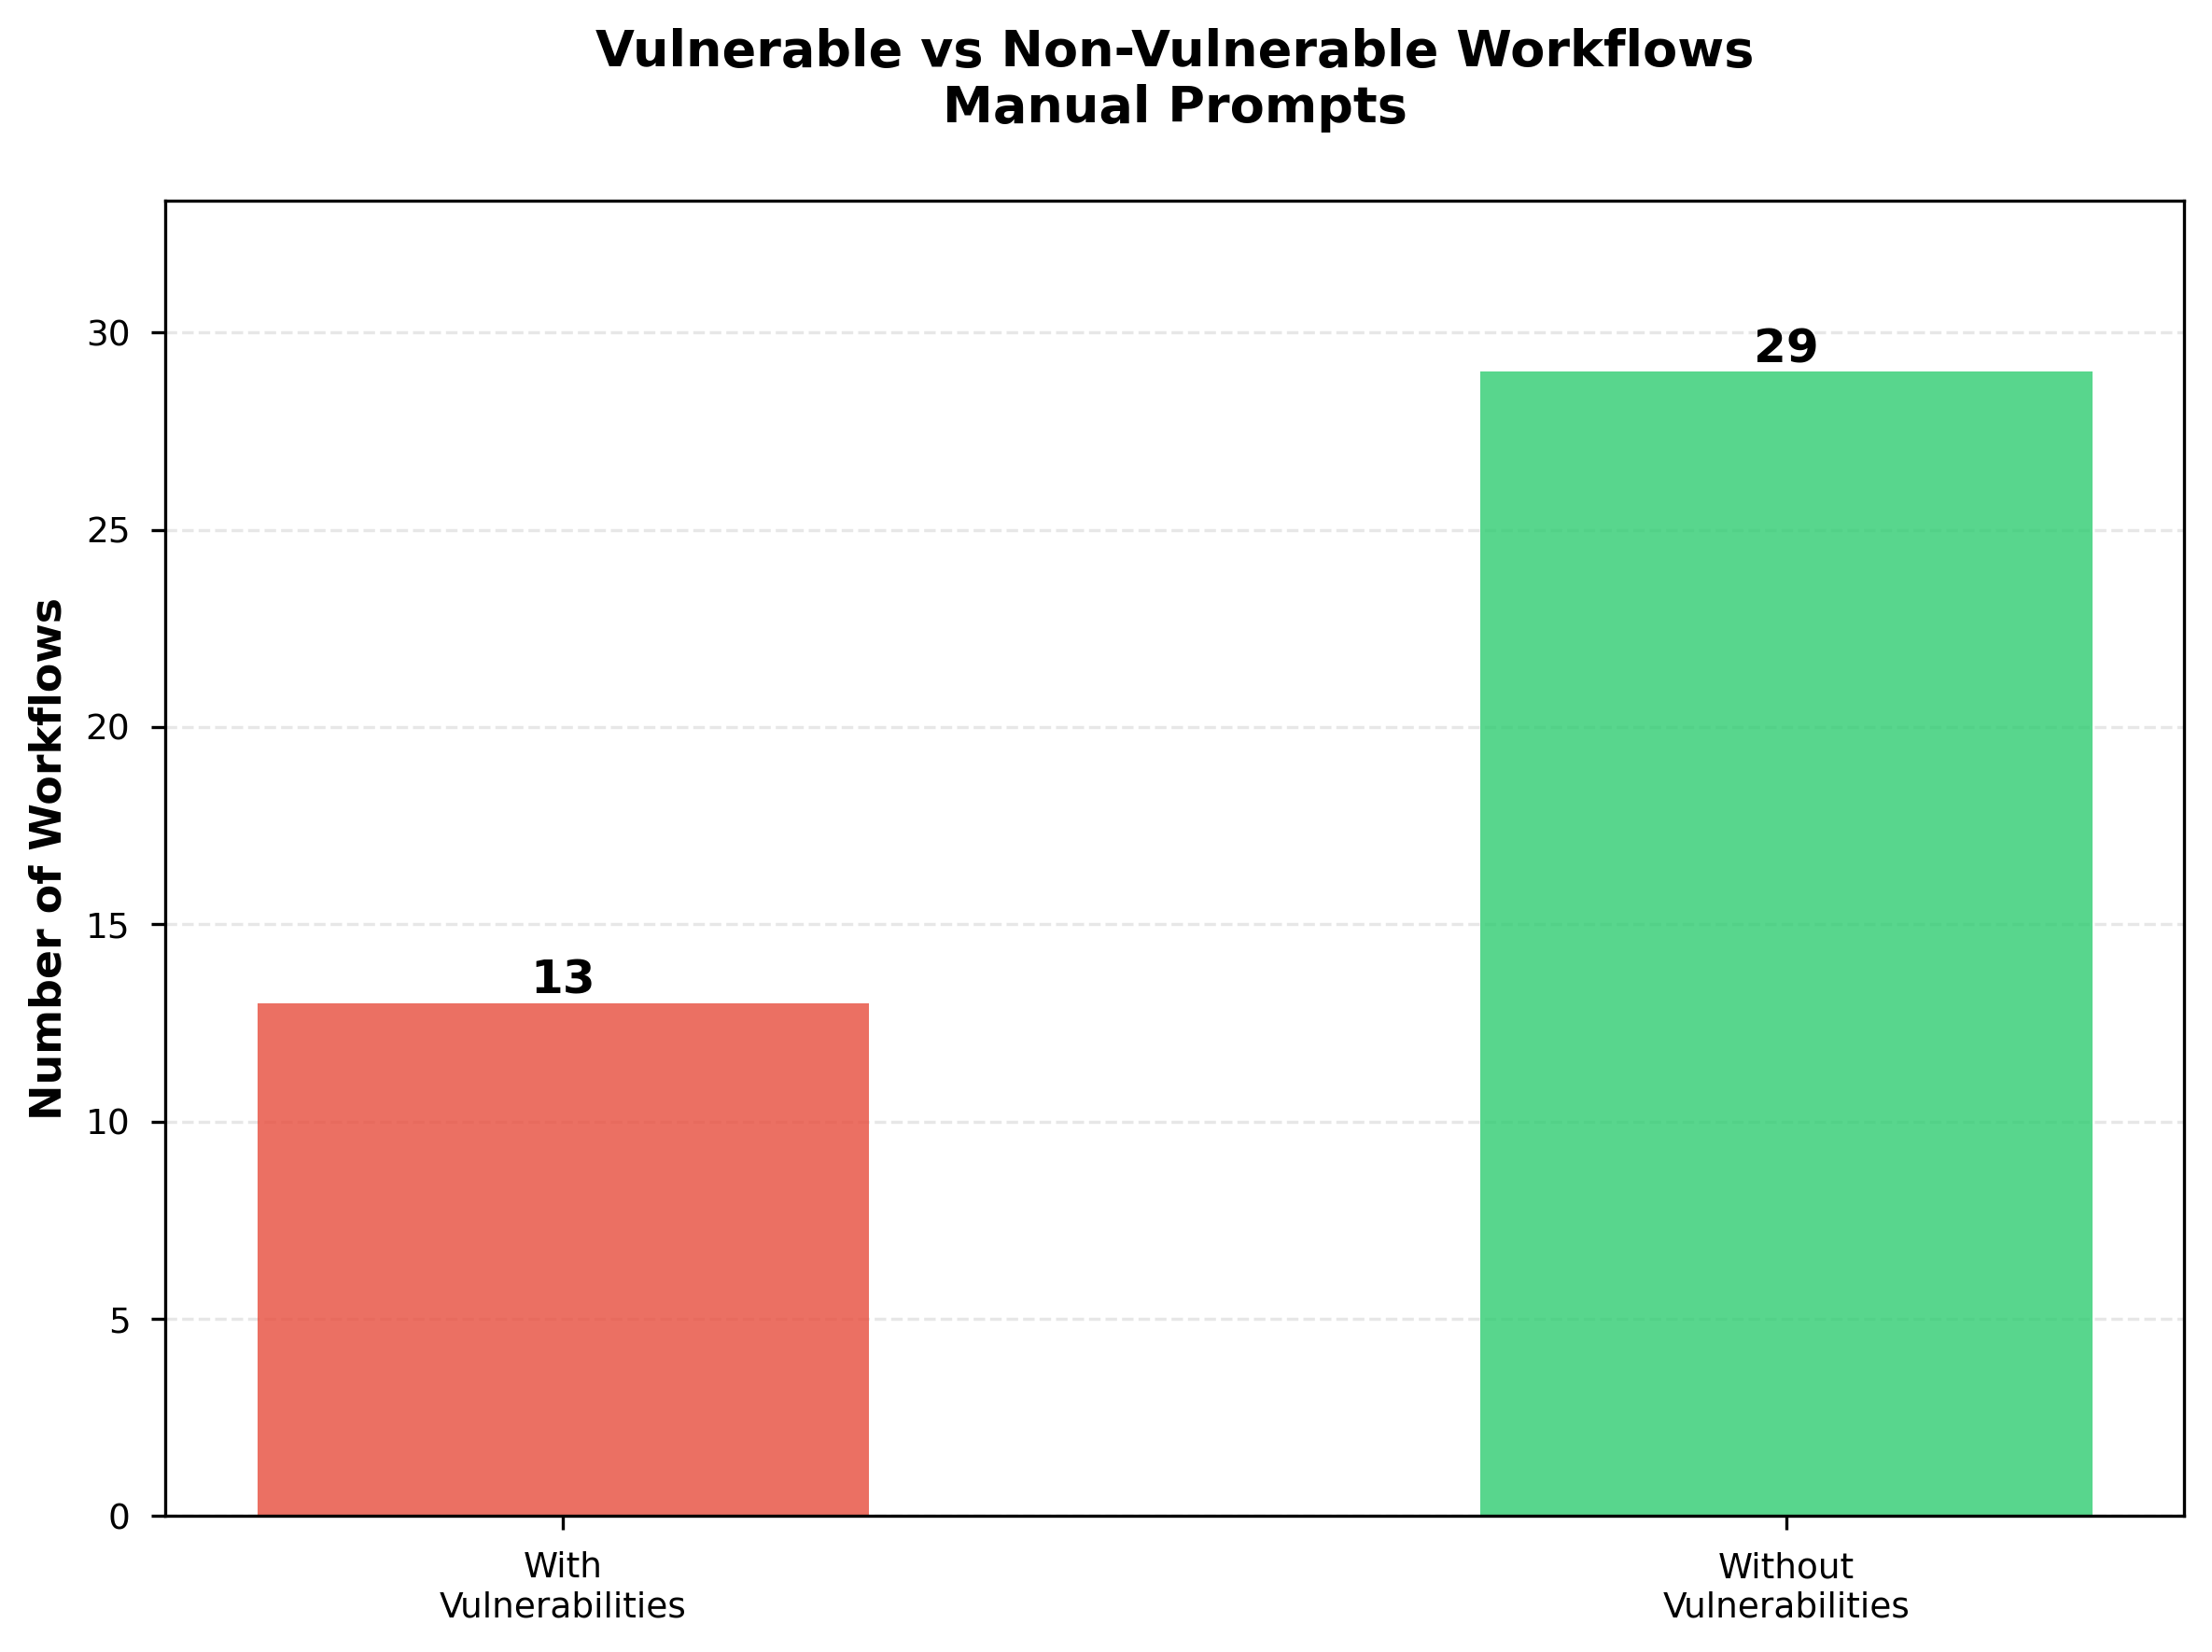

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1_securityeval_vulnerable_comparison.png


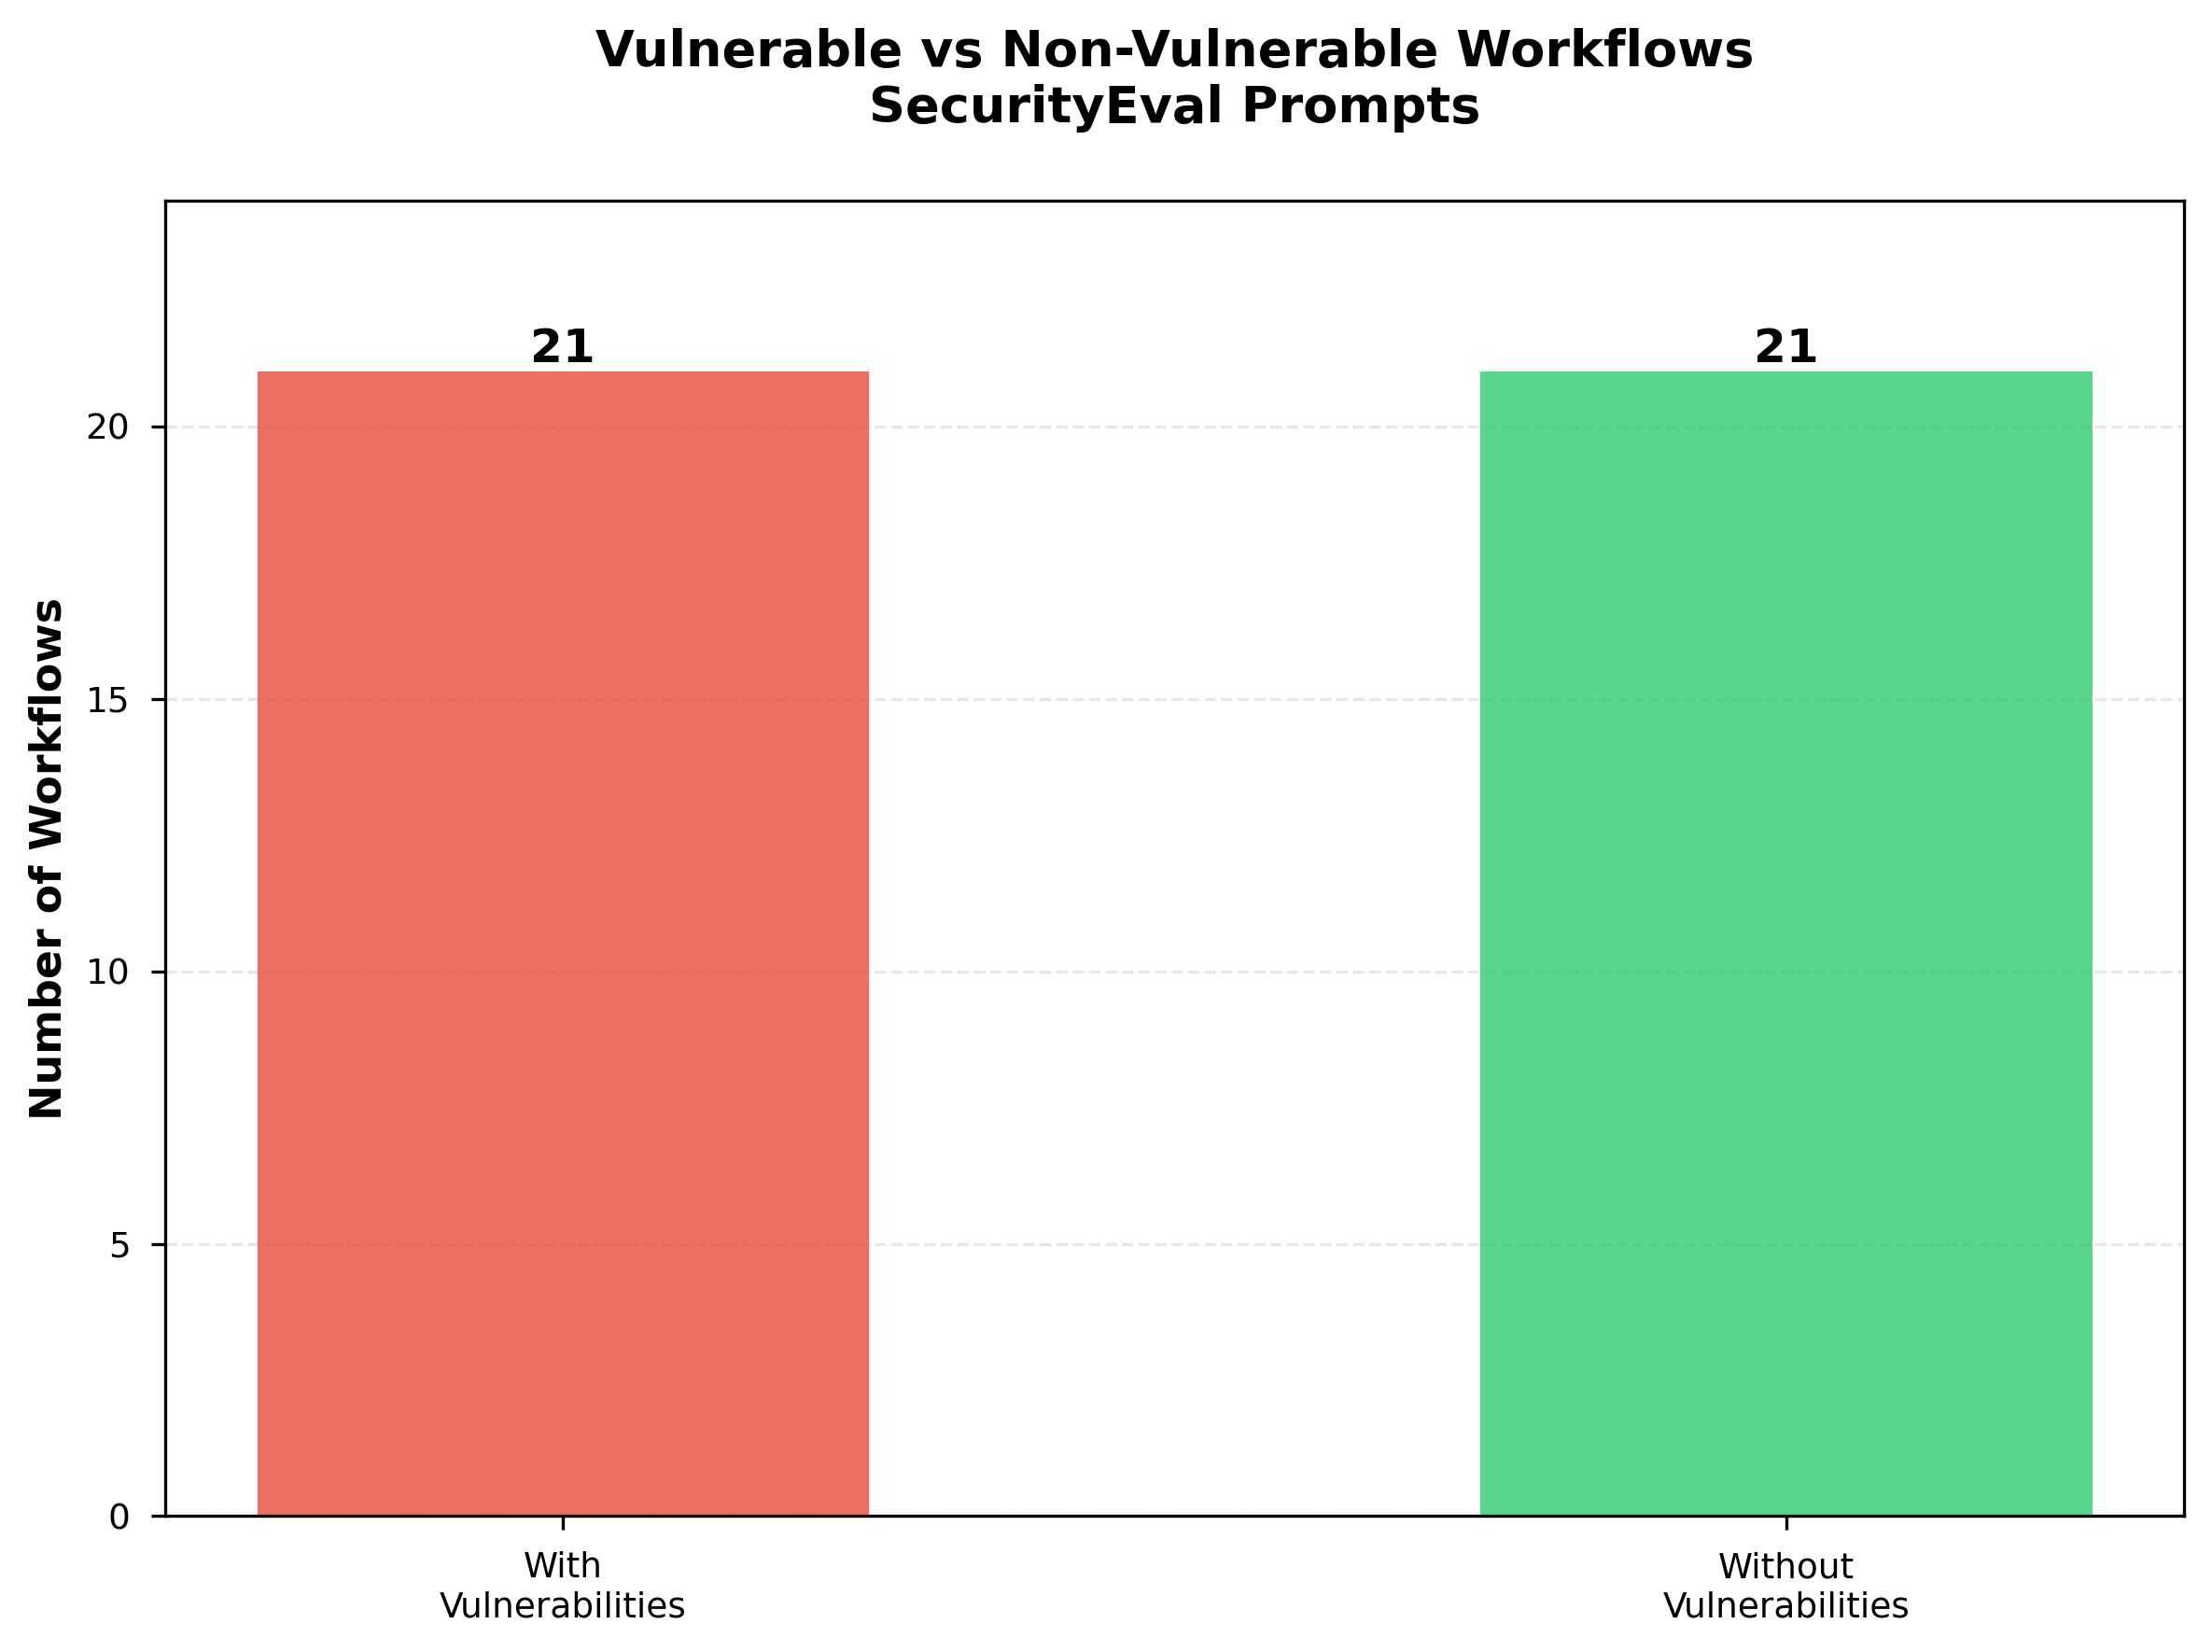


Both figures generated successfully!


In [5]:
# Prepare data for vulnerable vs non-vulnerable comparison
comparison_data = []
for prompt_type in ['Manual', 'SecurityEval']:
    df_subset = df[df['prompt_type'] == prompt_type]
    with_vulns = len(df_subset[df_subset['vulnerabilities_found'] > 0])
    without_vulns = len(df_subset[df_subset['vulnerabilities_found'] == 0])
    comparison_data.append({
        'Prompt Type': prompt_type,
        'With Vulnerabilities': with_vulns,
        'Without Vulnerabilities': without_vulns
    })

comparison_df = pd.DataFrame(comparison_data)

# Create two separate figures - one for each prompt type
for prompt_type in ['Manual', 'SecurityEval']:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Get data for this prompt type
    data = comparison_df[comparison_df['Prompt Type'] == prompt_type].iloc[0]
    
    categories = ['With\nVulnerabilities', 'Without\nVulnerabilities']
    values = [data['With Vulnerabilities'], data['Without Vulnerabilities']]
    colors_bars = ['#e74c3c', '#2ecc71']
    
    # Create bar chart
    bars = ax.bar(categories, values, color=colors_bars, alpha=0.8, width=0.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Number of Workflows', fontweight='bold', fontsize=11)
    ax.set_title(f'Vulnerable vs Non-Vulnerable Workflows\n{prompt_type} Prompts', 
                 fontweight='bold', pad=20, fontsize=13)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.set_ylim(0, max(values) * 1.15)  # Add some space at top for labels
    
    plt.tight_layout()
    
    # Save figure with prompt type in filename
    fig_path = FIGURES_DIR / f'fig1_{prompt_type.lower()}_vulnerable_comparison.png'
    plt.savefig(fig_path, bbox_inches='tight', dpi=300)
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

print("\nBoth figures generated successfully!")


### Figure 1b: CWEs in Vulnerable vs Non-Vulnerable SecurityEval Workflows

SECURITYEVAL: CWEs IN VULNERABLE VS NON-VULNERABLE WORKFLOWS

Vulnerable workflows: 21
Non-vulnerable workflows: 21

Total CWE-Author combinations found: 50
Unique CWEs: 33

Detailed breakdown:
    CWE Vulnerable Authors       Non-Vulnerable Authors  Vulnerable Count  Non-Vulnerable Count
CWE-020           author_1                     author_2                 1                     1
CWE-022           author_1                     author_2                 1                     1
CWE-078                  -                     author_1                 0                     1
CWE-080           author_1                            -                 1                     0
CWE-089                  -                     author_1                 0                     1
CWE-094           author_1                            -                 1                     0
CWE-095           author_1                            -                 1                     0
CWE-116                  -            

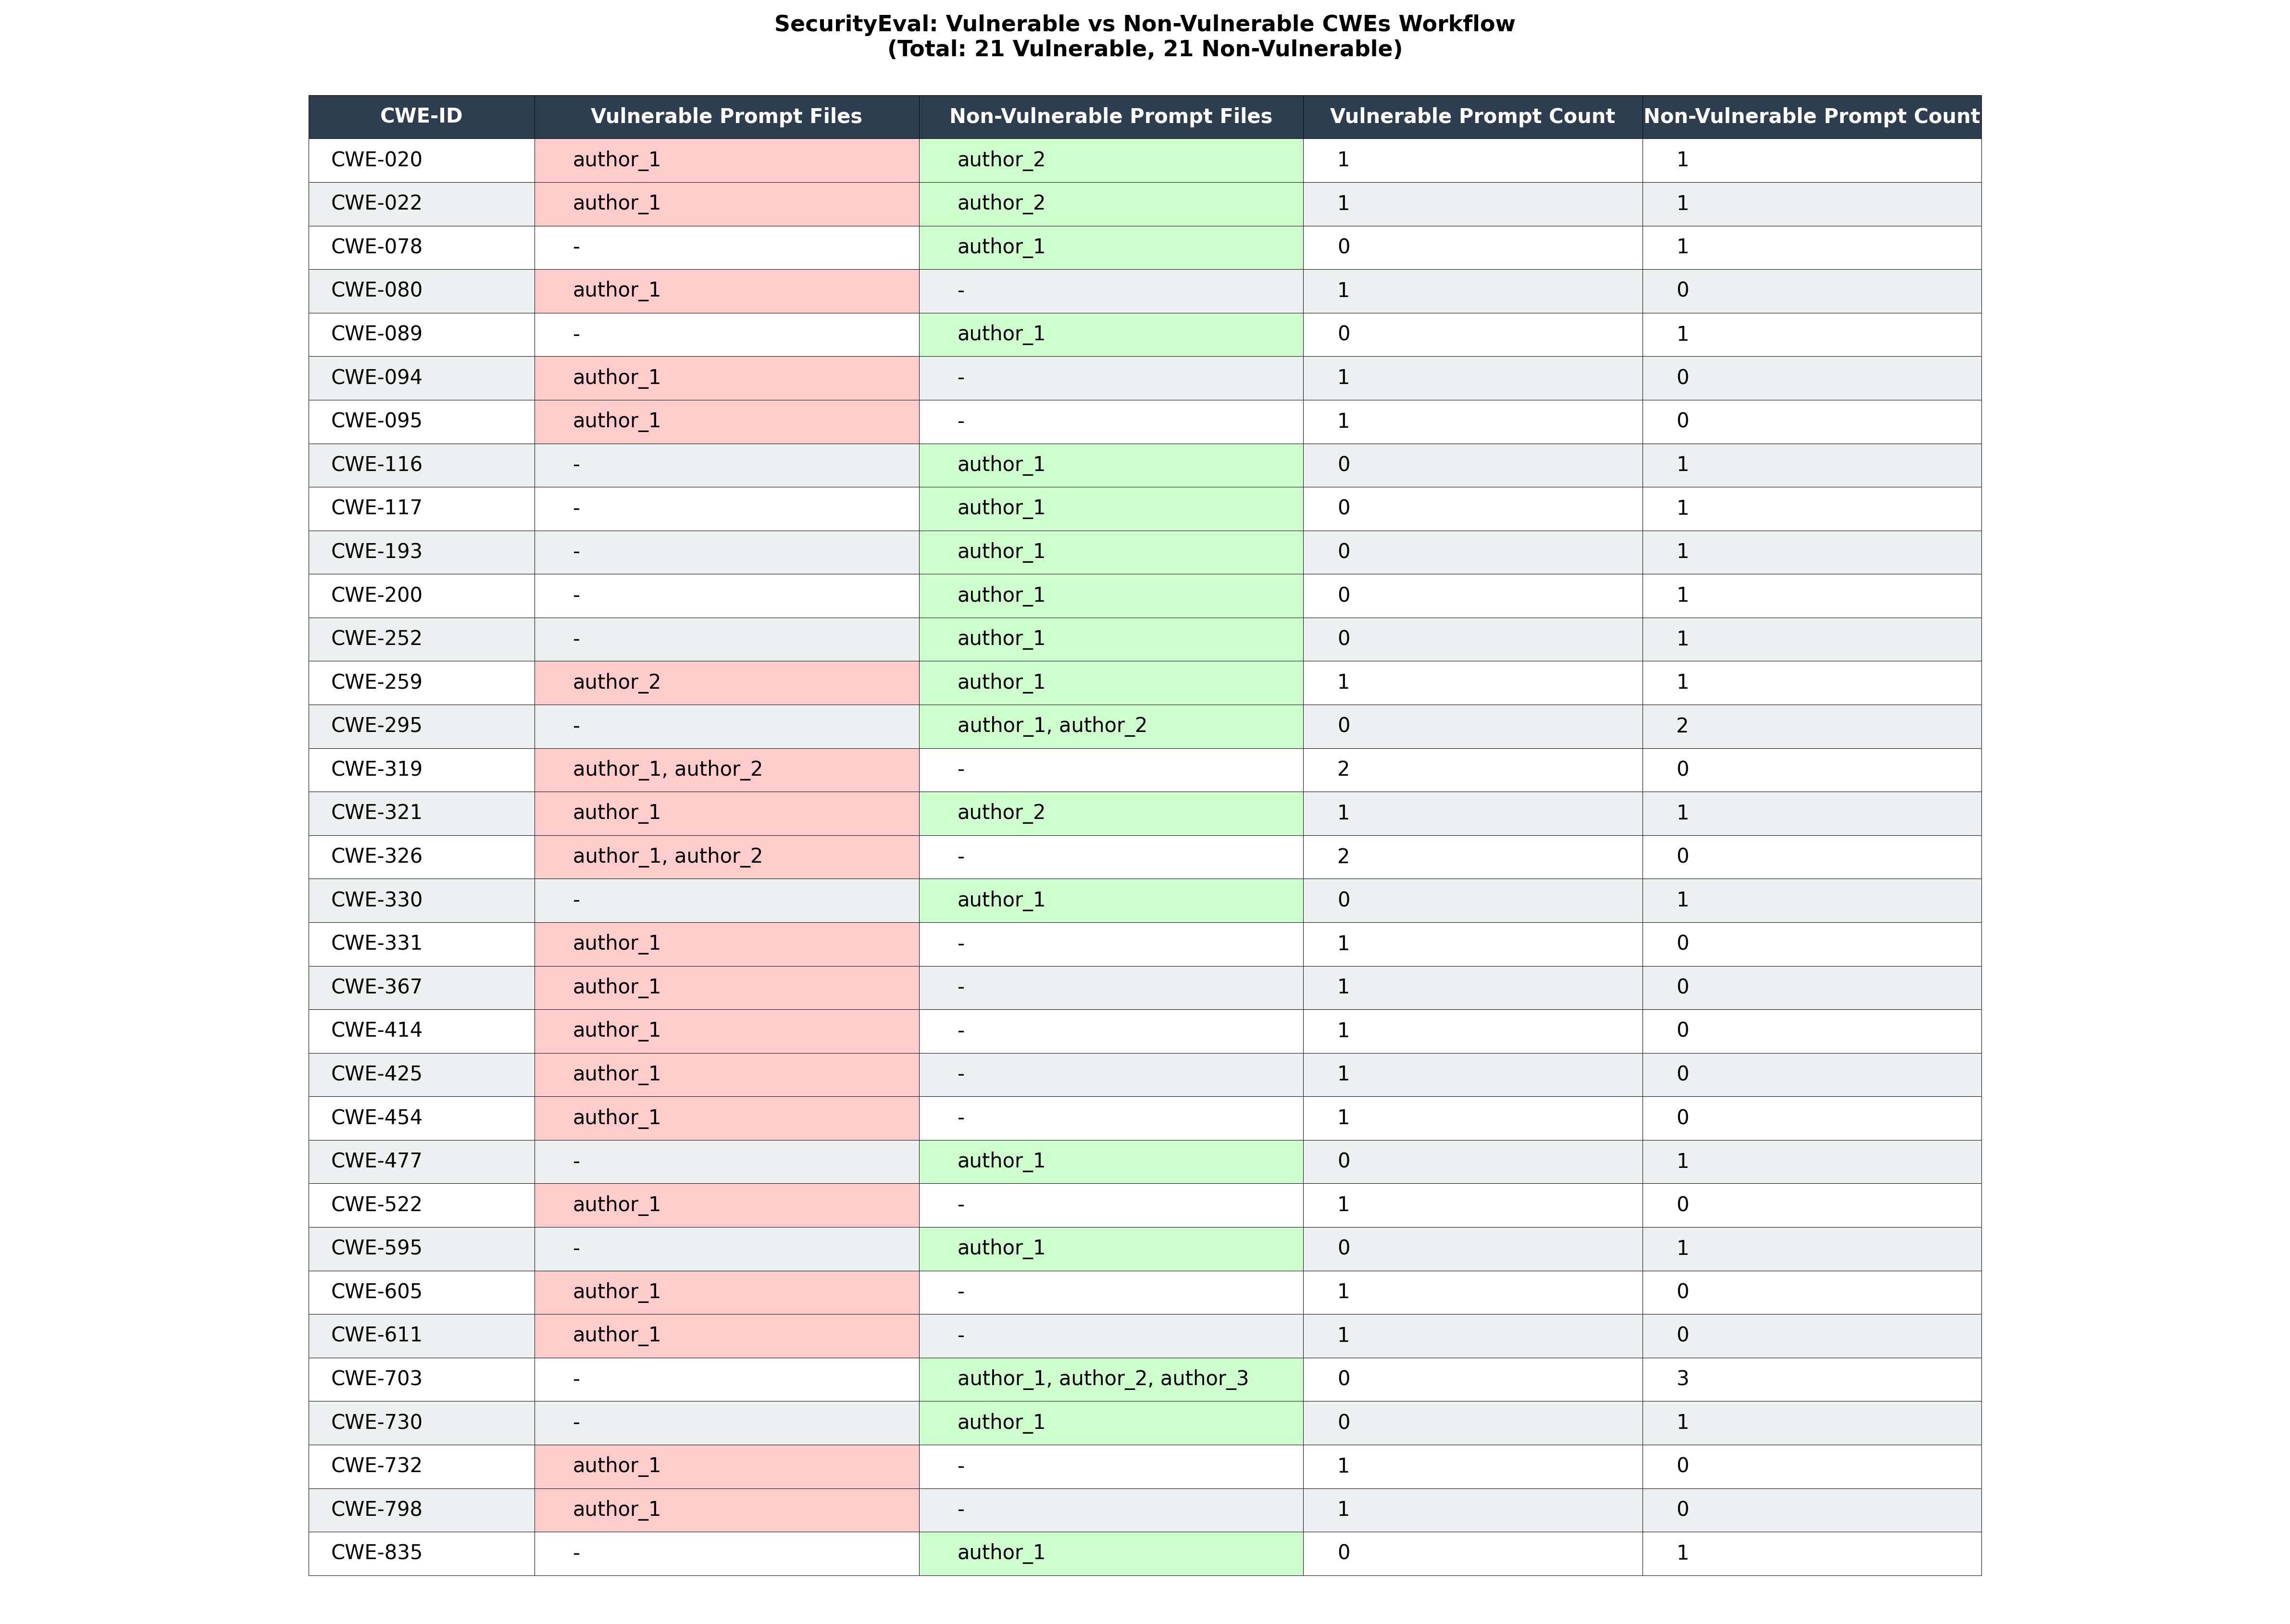

In [ ]:
# Focus on SecurityEval workflows only
df_securityeval = df[df['prompt_type'] == 'SecurityEval']

if len(df_securityeval) > 0:
    # Separate into vulnerable (with vulnerabilities) and non-vulnerable (without)
    vulnerable_workflows = df_securityeval[df_securityeval['vulnerabilities_found'] > 0]
    non_vulnerable_workflows = df_securityeval[df_securityeval['vulnerabilities_found'] == 0]
    
    print("=" * 80)
    print("SECURITYEVAL: CWEs IN VULNERABLE VS NON-VULNERABLE WORKFLOWS")
    print("=" * 80)
    print(f"\nVulnerable workflows: {len(vulnerable_workflows)}")
    print(f"Non-vulnerable workflows: {len(non_vulnerable_workflows)}")
    
    # Build detailed data showing CWE-Author relationships from file paths
    detailed_data = []
    
    # Process vulnerable workflows
    for idx, row in vulnerable_workflows.iterrows():
        # Extract CWE and Author from file path (e.g., "CWE-020/author_1.py")
        file_path = row.get('file', '')
        if file_path and '/' in file_path:
            parts = file_path.split('/')
            cwe_from_path = parts[0]  # e.g., "CWE-020"
            author_file = parts[1].replace('.py', '')  # e.g., "author_1"
        else:
            # Fallback to workflow_id if file column not available
            workflow_id = row['workflow_id']
            cwe_from_path = workflow_id.split('_')[0] if '_' in workflow_id else ''
            author_file = workflow_id.split('_', 1)[1] if '_' in workflow_id else workflow_id
        
        cwe_columns = [
            'initial_detection_bandit_cwes',
            'initial_detection_semgrep_cwes',
            'initial_detection_ast_cwes'
        ]
        
        cwes_in_workflow = set()
        for col in cwe_columns:
            cwes = row[col]
            if isinstance(cwes, str):
                try:
                    cwes = eval(cwes)
                except:
                    cwes = []
            if isinstance(cwes, list):
                cwes_in_workflow.update(cwes)
        
        for cwe in cwes_in_workflow:
            detailed_data.append({
                'CWE': f'CWE-{cwe}',
                'CWE_from_path': cwe_from_path,
                'Author': author_file,
                'Category': 'Vulnerable'
            })
    
    # Process non-vulnerable workflows
    for idx, row in non_vulnerable_workflows.iterrows():
        # Extract CWE and Author from file path
        file_path = row.get('file', '')
        if file_path and '/' in file_path:
            parts = file_path.split('/')
            cwe_from_path = parts[0]
            author_file = parts[1].replace('.py', '')
        else:
            workflow_id = row['workflow_id']
            cwe_from_path = workflow_id.split('_')[0] if '_' in workflow_id else ''
            author_file = workflow_id.split('_', 1)[1] if '_' in workflow_id else workflow_id
        
        # For non-vulnerable workflows, record the CWE-Author combination from the file path
        # even if no vulnerabilities were detected
        if cwe_from_path:
            detailed_data.append({
                'CWE': cwe_from_path,  # Use CWE from path directly
                'CWE_from_path': cwe_from_path,
                'Author': author_file,
                'Category': 'Non-Vulnerable'
            })
    
    if detailed_data:
        # Create DataFrame
        detail_df = pd.DataFrame(detailed_data)
        
        # Group by CWE from path and Category to get author lists
        summary_data = []
        all_cwes = sorted(detail_df['CWE_from_path'].unique())
        
        for cwe_path in all_cwes:
            cwe_data = detail_df[detail_df['CWE_from_path'] == cwe_path]
            
            vulnerable_authors = cwe_data[cwe_data['Category'] == 'Vulnerable']['Author'].tolist()
            non_vulnerable_authors = cwe_data[cwe_data['Category'] == 'Non-Vulnerable']['Author'].tolist()
            
            # Use set() to get unique authors (remove duplicates from same file detecting multiple CWEs)
            unique_vulnerable_authors = sorted(set(vulnerable_authors))
            unique_non_vulnerable_authors = sorted(set(non_vulnerable_authors))
            
            summary_data.append({
                'CWE': cwe_path,
                'Vulnerable Authors': ', '.join(unique_vulnerable_authors) if unique_vulnerable_authors else '-',
                'Non-Vulnerable Authors': ', '.join(unique_non_vulnerable_authors) if unique_non_vulnerable_authors else '-',
                'Vulnerable Count': len(unique_vulnerable_authors),
                'Non-Vulnerable Count': len(unique_non_vulnerable_authors)
            })
        
        summary_df = pd.DataFrame(summary_data)
        
        print(f"\nTotal CWE-Author combinations found: {len(detail_df)}")
        print(f"Unique CWEs: {len(all_cwes)}")
        print(f"\nDetailed breakdown:")
        print(summary_df.to_string(index=False))
        
        # Create table visualization
        fig, ax = plt.subplots(figsize=(16, max(6, len(summary_df) * 0.35)))
        ax.axis('tight')
        ax.axis('off')
        
        # Prepare table data
        table_data = []
        for _, row in summary_df.iterrows():
            table_data.append([
                row['CWE'],
                row['Vulnerable Authors'],
                row['Non-Vulnerable Authors'],
                int(row['Vulnerable Count']),
                int(row['Non-Vulnerable Count'])
            ])
        
        # Create table
        table = ax.table(cellText=table_data,
                        colLabels=['CWE-ID', 'Vulnerable Prompt Files', 'Non-Vulnerable Prompt Files', 
                                  'Vulnerable Prompt Count', 'Non-Vulnerable Prompt Count'],
                        cellLoc='left',
                        loc='center',
                        colWidths=[0.10, 0.17, 0.17, 0.15, 0.15])
        
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        # Style the header
        for i in range(5):
            cell = table[(0, i)]
            cell.set_facecolor('#2c3e50')
            cell.set_text_props(weight='bold', color='white')
        
        # Style data rows with alternating colors
        for i in range(1, len(table_data) + 1):
            for j in range(5):
                cell = table[(i, j)]
                if i % 2 == 0:
                    cell.set_facecolor('#ecf0f1')
                else:
                    cell.set_facecolor('#ffffff')
                
                # Highlight vulnerable vs non-vulnerable
                if j == 1 and table_data[i-1][3] > 0:  # Vulnerable Authors column
                    cell.set_facecolor('#ffcccc')
                elif j == 2 and table_data[i-1][4] > 0:  # Non-Vulnerable Authors column
                    cell.set_facecolor('#ccffcc')
        
        plt.title(f'SecurityEval: Vulnerable vs Non-Vulnerable CWEs Workflow\n'
                 f'(Total: {len(vulnerable_workflows)} Vulnerable, {len(non_vulnerable_workflows)} Non-Vulnerable)',
                 fontweight='bold', fontsize=11, pad=-5)
        
        plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.02)
        
        # Save figure
        fig_path = FIGURES_DIR / 'fig1b_securityeval_cwes_vulnerable_comparison.png'
        plt.savefig(fig_path, bbox_inches='tight', dpi=300)
        print(f"\n✓ Figure saved: {fig_path}")
        
        plt.show()
    else:
        print("\n No CWE data available")
else:
    print("\n No SecurityEval data available")

### Figure 2: Histogram of Vulnerabilities Found

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig2_manual_vulnerabilities_histogram.png


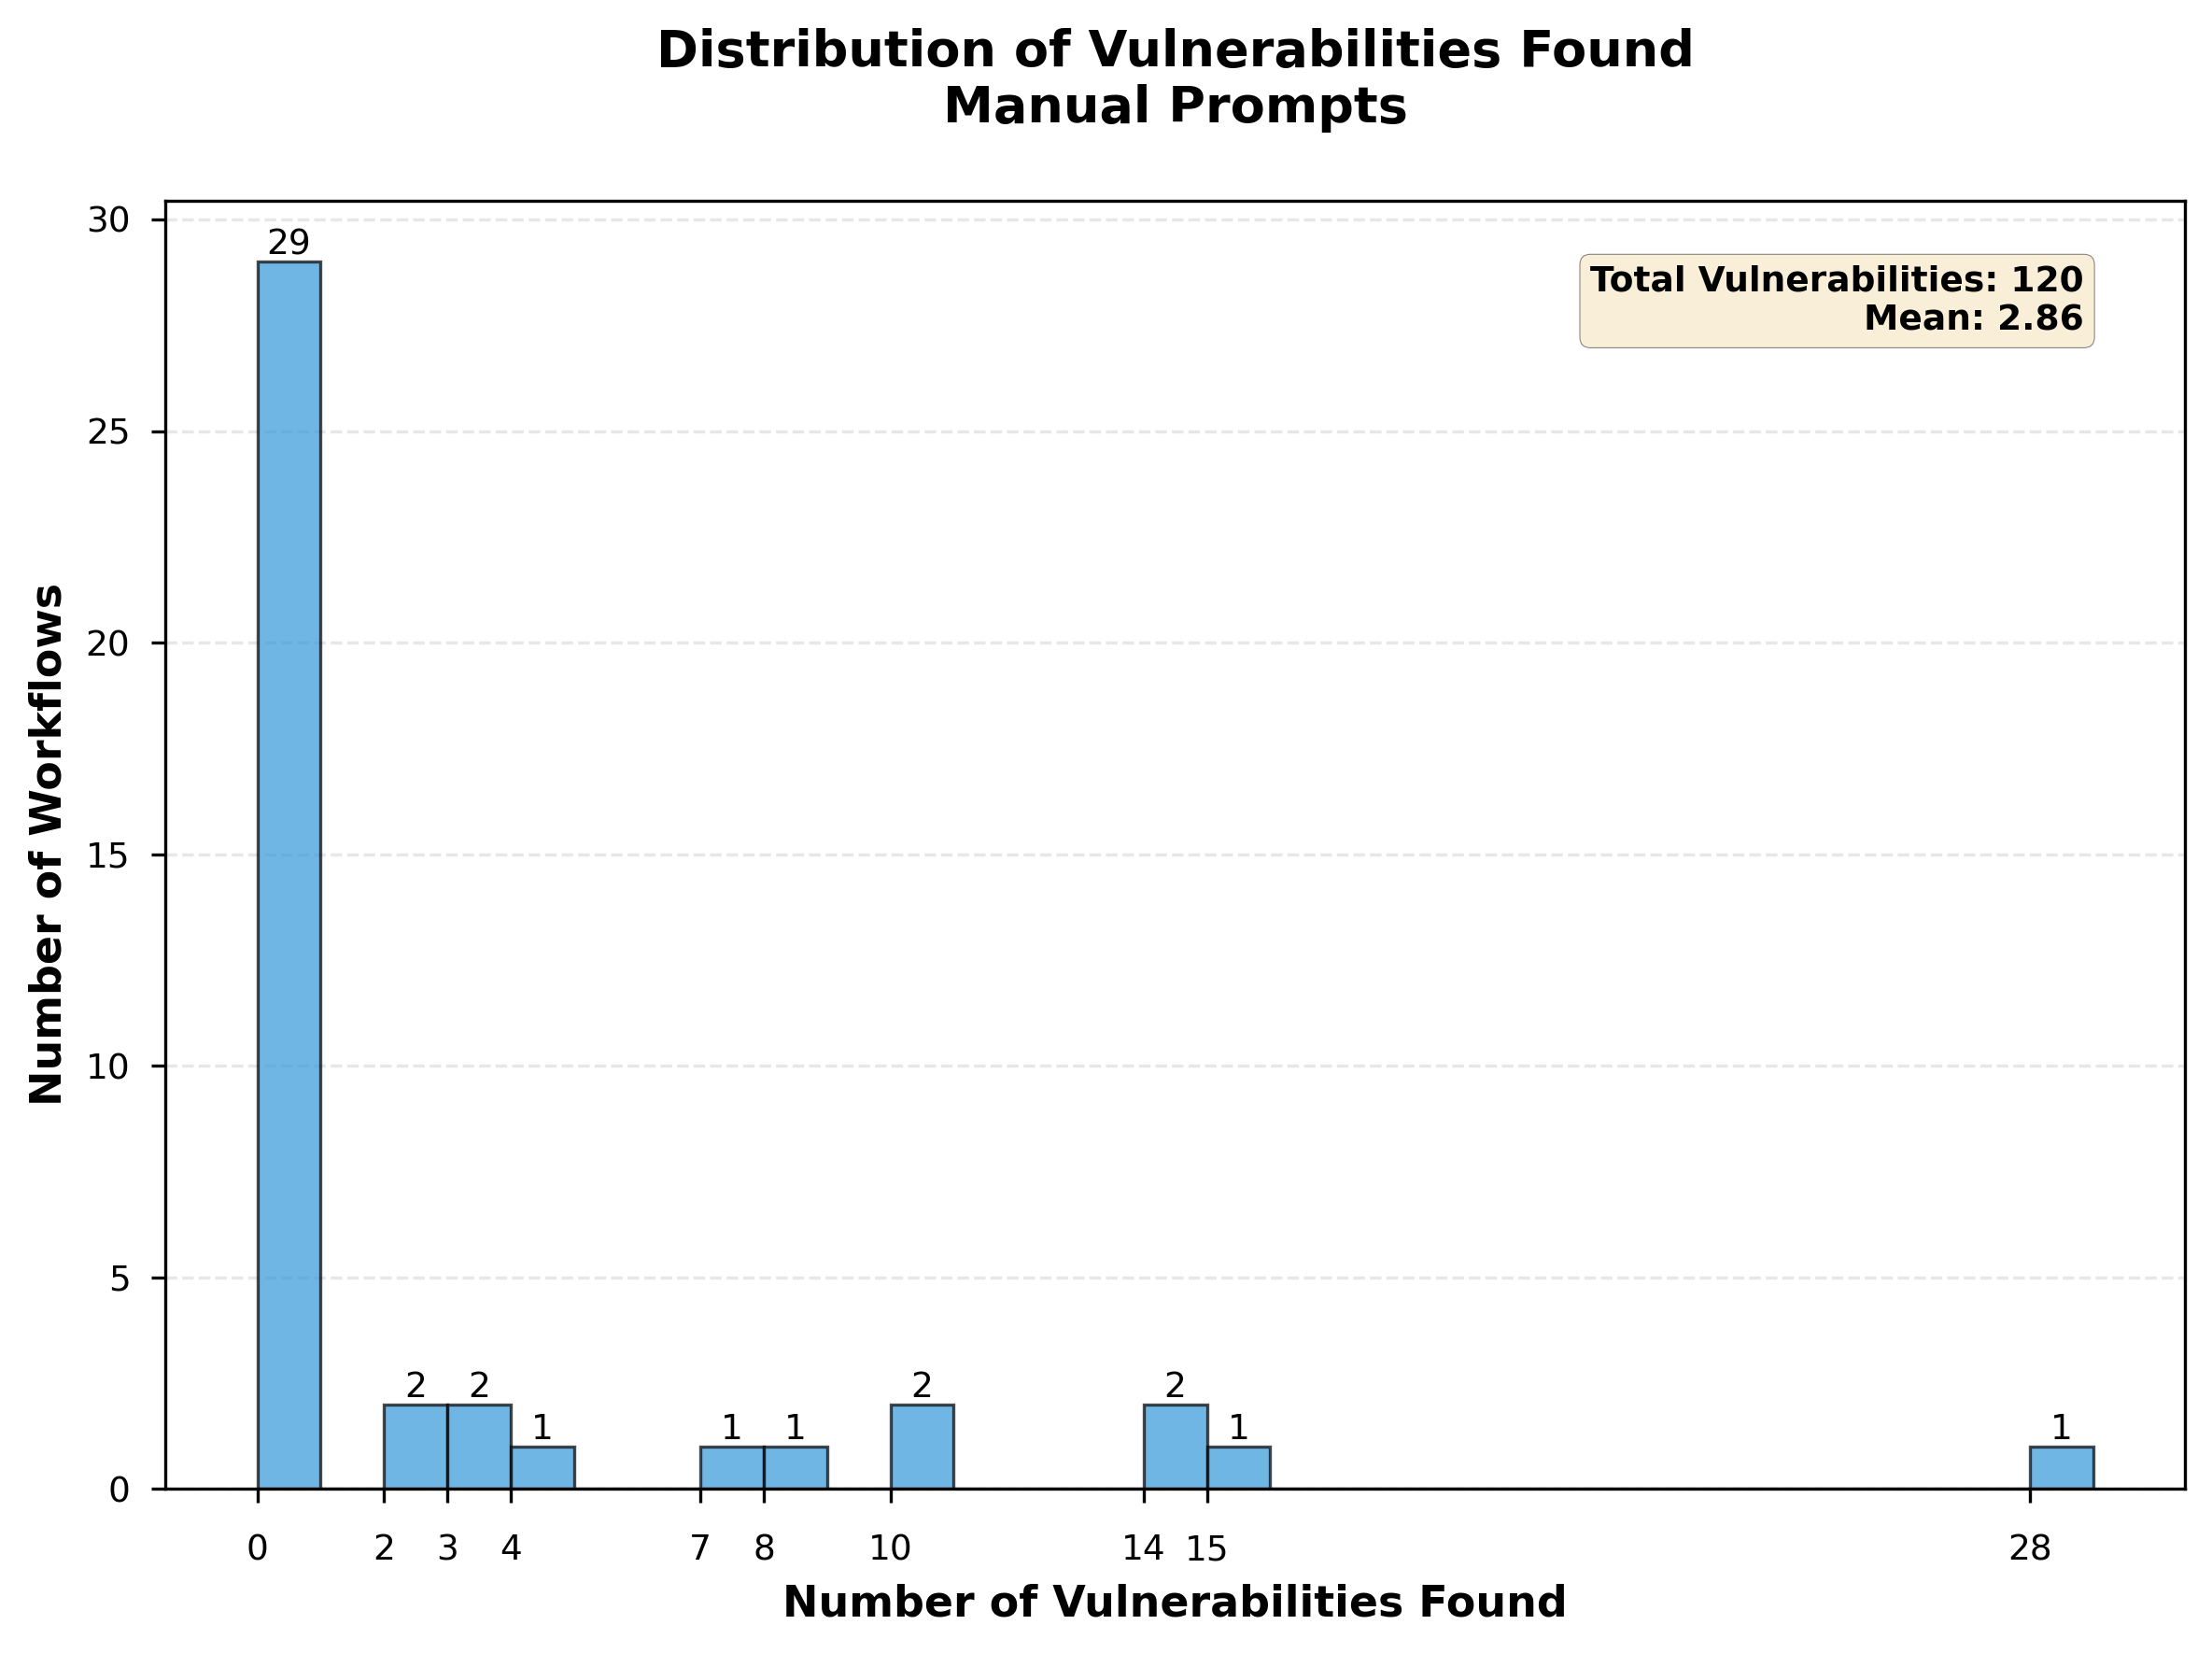

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig2_securityeval_vulnerabilities_histogram.png


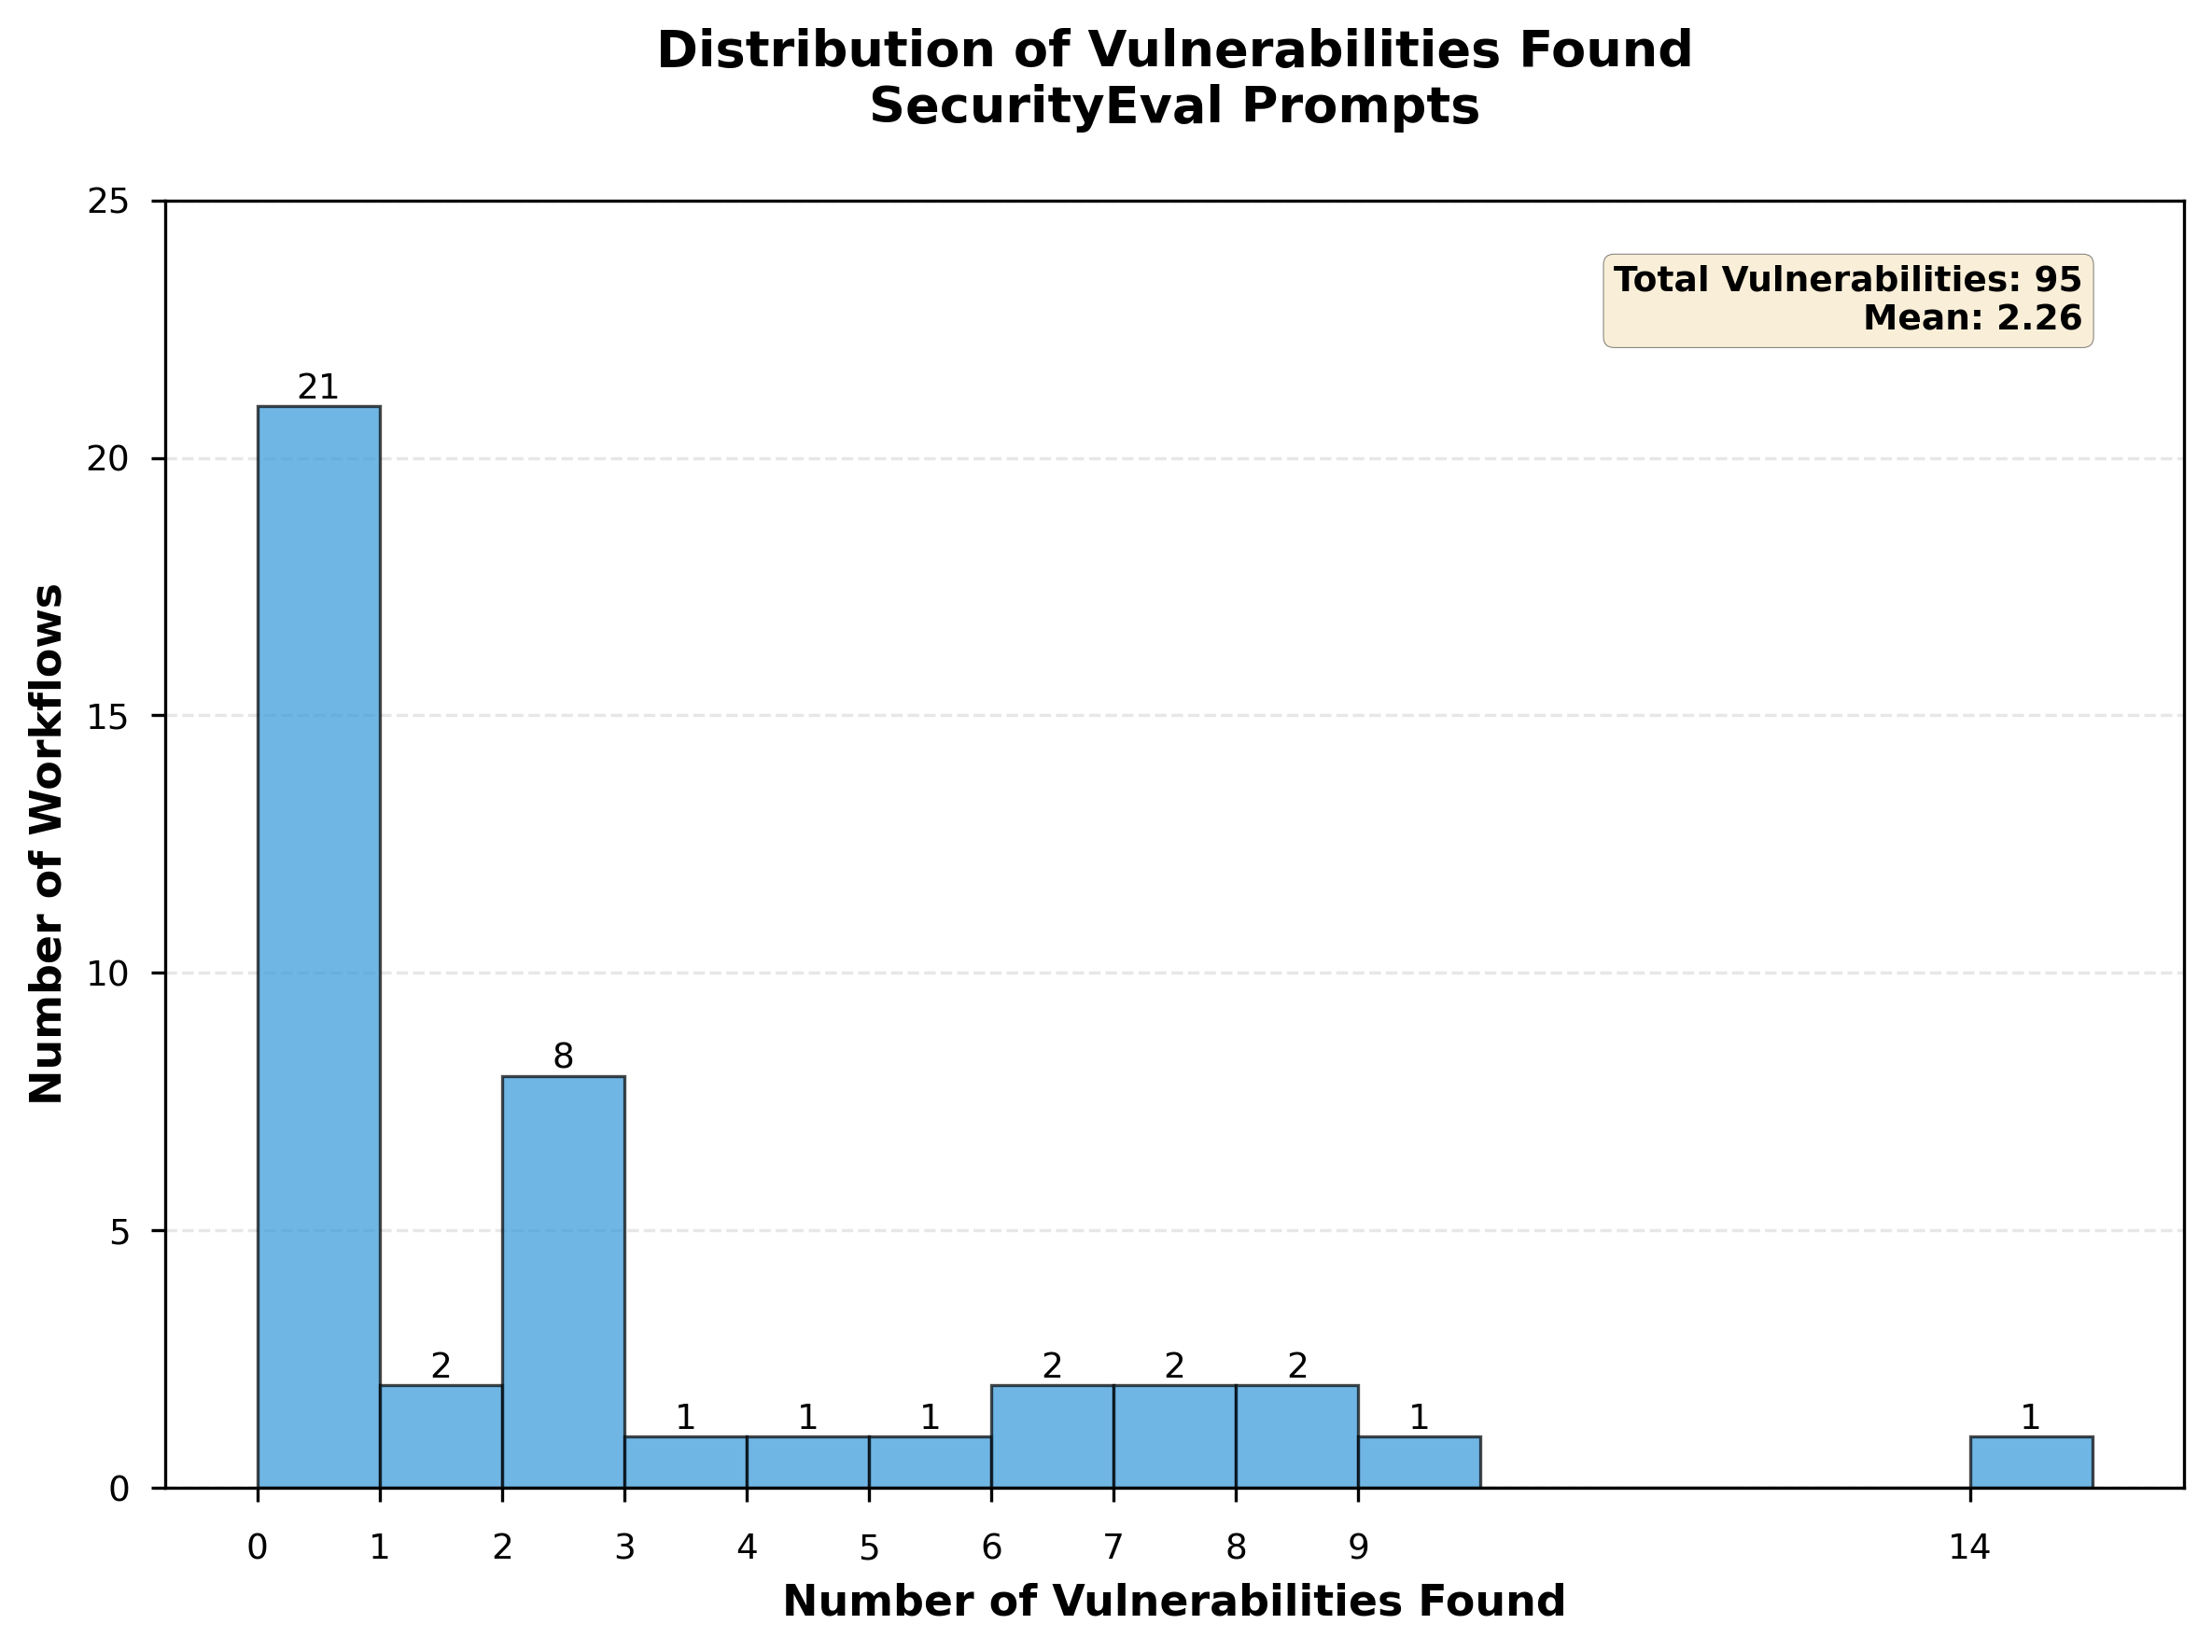


Both histogram figures generated successfully!


In [7]:
# Create separate histograms for each prompt type
for prompt_type in ['Manual', 'SecurityEval']:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    df_subset = df[df['prompt_type'] == prompt_type]
    
    if len(df_subset) > 0:
        # Get max value safely
        max_val = int(df_subset['vulnerabilities_found'].max())
        if pd.isna(max_val) or max_val < 0:
            max_val = 0
        
        # Create histogram
        counts, bins, patches = ax.hist(df_subset['vulnerabilities_found'], 
                                         bins=range(0, max_val + 2),
                                         color='#3498db', alpha=0.7, edgecolor='black', linewidth=0.8)
        
        # Add value labels on bars
        for count, patch in zip(counts, patches):
            if count > 0:
                height = patch.get_height()
                ax.text(patch.get_x() + patch.get_width()/2., height,
                        f'{int(count)}',
                        ha='center', va='bottom', fontsize=9)
        
        # Only show x-ticks where there are actual bars (non-zero counts)
        x_ticks_with_data = [int(bins[i]) for i, count in enumerate(counts) if count > 0]
        ax.set_xticks(x_ticks_with_data)
        ax.set_xticklabels(x_ticks_with_data, fontsize=9)
        ax.tick_params(axis='x', pad=8)  # Add spacing between x-axis and labels
        
        ax.set_xlabel('Number of Vulnerabilities Found', fontweight='bold', fontsize=11)
        ax.set_ylabel('Number of Workflows', fontweight='bold', fontsize=11)
        ax.set_title(f'Distribution of Vulnerabilities Found\n{prompt_type} Prompts', 
                     fontweight='bold', pad=20, fontsize=13)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # Set y-axis to show specific ticks for SecurityEval
        if prompt_type == 'SecurityEval':
            ax.set_yticks([0, 5, 10, 15, 20, 25])
            ax.set_yticklabels([0, 5, 10, 15, 20, 25], fontsize=9)
        
        # Add statistics text box with bold labels
        total_vulns = df_subset['vulnerabilities_found'].sum()
        mean_vulns = df_subset['vulnerabilities_found'].mean()
        stats_text = f"Total Vulnerabilities: {int(total_vulns)}\nMean: {mean_vulns:.2f}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'No data available for {prompt_type}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xlabel('Number of Vulnerabilities Found', fontweight='bold', fontsize=11)
        ax.set_ylabel('Number of Workflows', fontweight='bold', fontsize=11)
        ax.set_title(f'Distribution of Vulnerabilities Found\n{prompt_type} Prompts', 
                     fontweight='bold', pad=20, fontsize=13)

    plt.tight_layout()
    
    # Save figure with prompt type in filename
    fig_path = FIGURES_DIR / f'fig2_{prompt_type.lower()}_vulnerabilities_histogram.png'
    plt.savefig(fig_path, bbox_inches='tight', dpi=300)
    print(f"✓ Figure saved: {fig_path}")
    
    plt.show()

print("\nBoth histogram figures generated successfully!")

### Figure 3: Top 10 CWE Frequency Analysis

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig3_top10_cwes.png


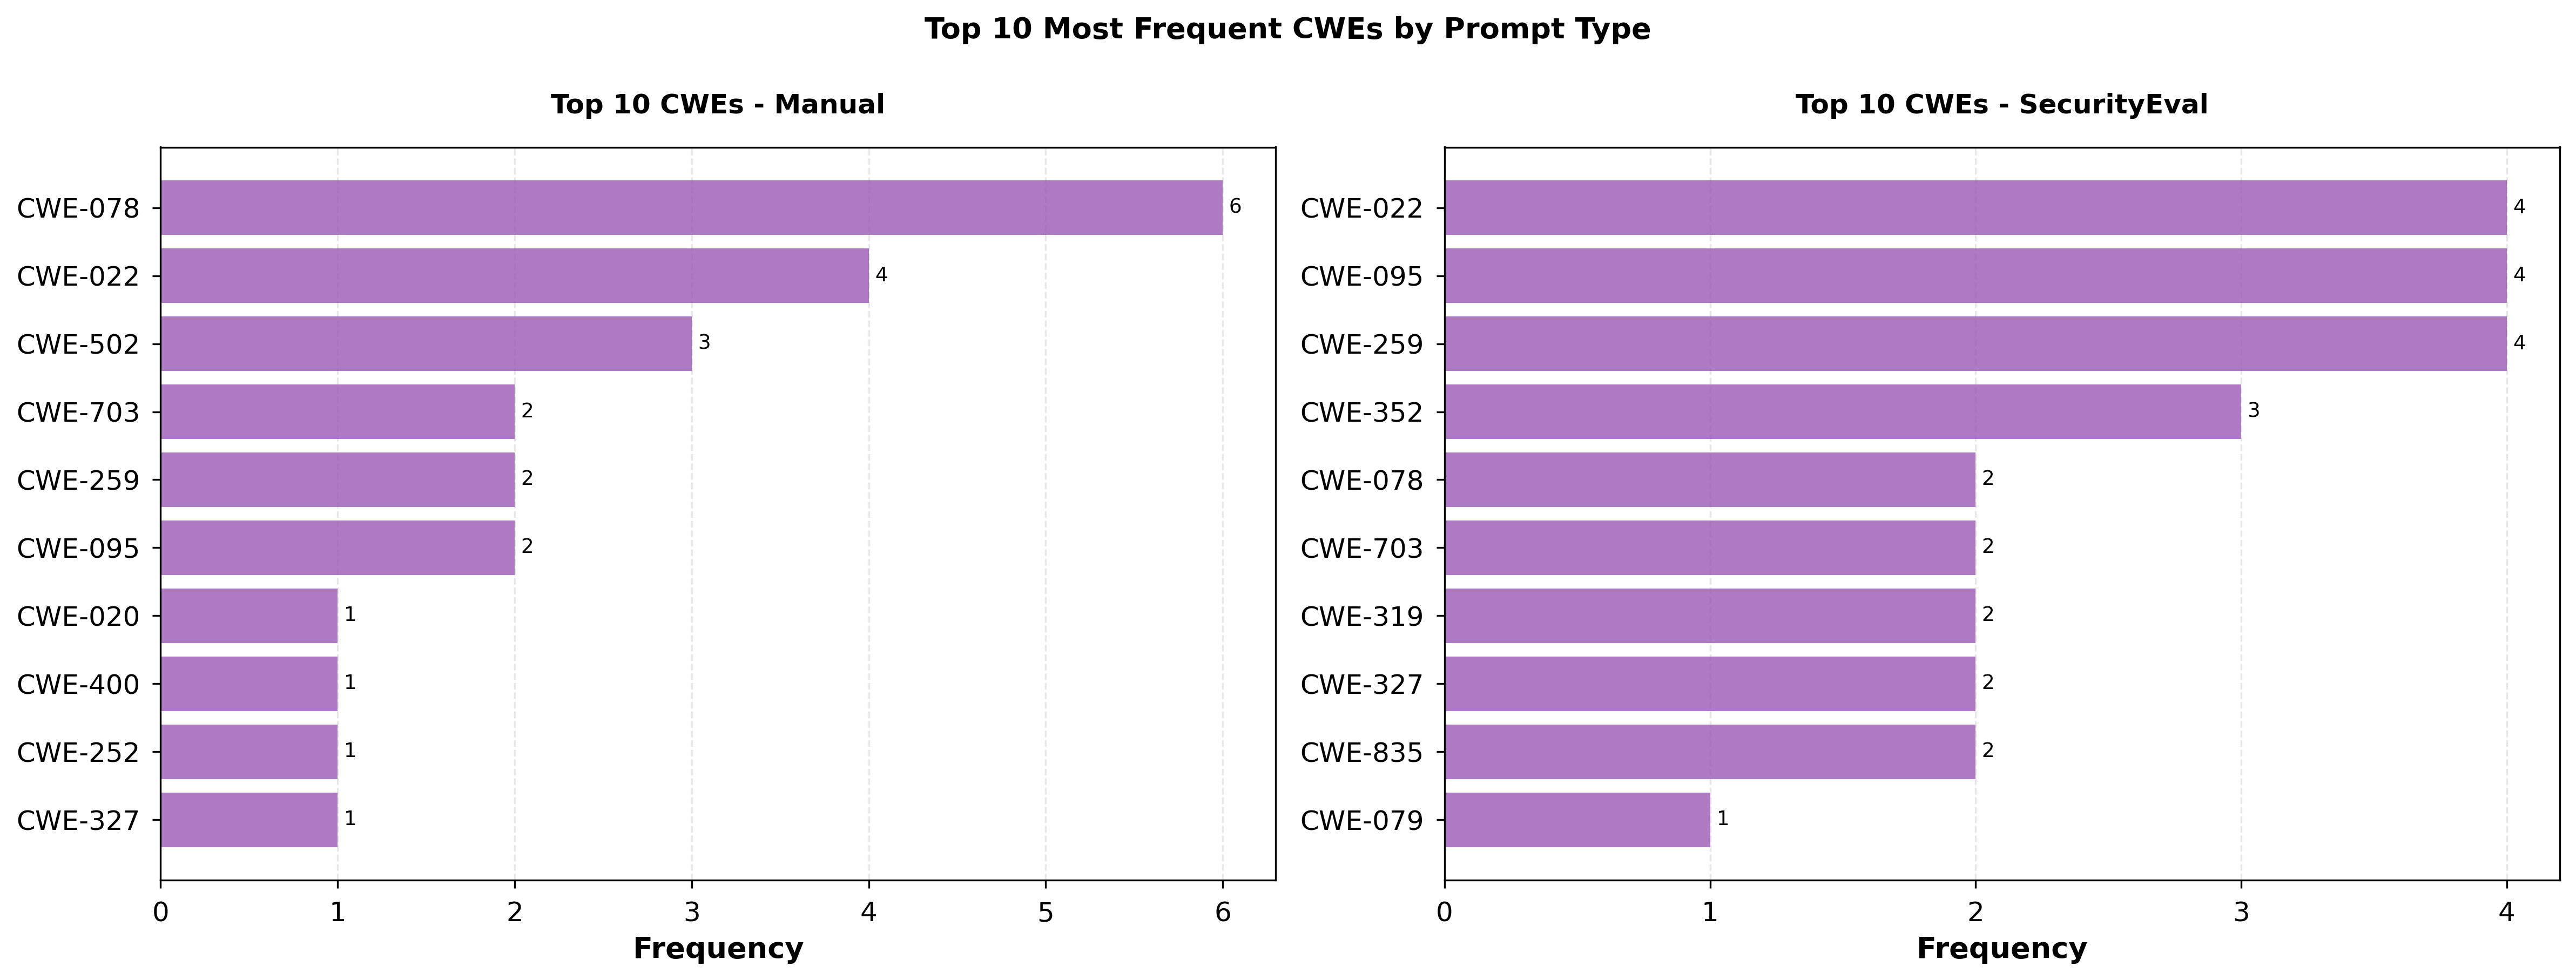

In [8]:
def extract_all_cwes(df_subset: pd.DataFrame) -> List[str]:
    """
    Extract all CWEs from initial detection columns.
    
    Args:
        df_subset: DataFrame subset for a prompt type
        
    Returns:
        List of all CWE IDs found
    """
    all_cwes = []
    
    cwe_columns = [
        'initial_detection_bandit_cwes',
        'initial_detection_semgrep_cwes',
        'initial_detection_ast_cwes'
    ]
    
    for _, row in df_subset.iterrows():
        for col in cwe_columns:
            cwes = row[col]
            # Handle string representation of lists
            if isinstance(cwes, str):
                try:
                    cwes = eval(cwes)
                except:
                    cwes = []
            if isinstance(cwes, list):
                all_cwes.extend(cwes)
    
    return all_cwes

# Create side-by-side bar charts for top 10 CWEs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, prompt_type in enumerate(['Manual', 'SecurityEval']):
    df_subset = df[df['prompt_type'] == prompt_type]
    
    # Extract all CWEs
    all_cwes = extract_all_cwes(df_subset)
    
    # Count CWE frequencies
    if all_cwes:
        cwe_counts = pd.Series(all_cwes).value_counts().head(10)
        
        ax = axes[idx]
        
        # Create bar chart
        bars = ax.barh(range(len(cwe_counts)), cwe_counts.values, color='#9b59b6', alpha=0.8)
        
        # Add value labels
        for i, (cwe, count) in enumerate(zip(cwe_counts.index, cwe_counts.values)):
            ax.text(count, i, f' {count}', va='center', fontsize=9)
        
        ax.set_yticks(range(len(cwe_counts)))
        ax.set_yticklabels([f'CWE-{cwe}' for cwe in cwe_counts.index], fontsize=12)
        ax.invert_yaxis()
        ax.set_xlabel('Frequency', fontweight='bold', fontsize=13)
        
        # Set x-axis to show integer ticks
        max_freq = int(cwe_counts.values.max())
        ax.set_xticks(range(0, max_freq + 1))
        ax.set_xticklabels(range(0, max_freq + 1), fontsize=12)
        
        ax.set_title(f'Top 10 CWEs - {prompt_type}', fontweight='bold', pad=15)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
    else:
        axes[idx].text(0.5, 0.5, 'No CWE data available', 
                       ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Top 10 CWEs - {prompt_type}', fontweight='bold', pad=15)

fig.suptitle('Top 10 Most Frequent CWEs by Prompt Type', 
             fontweight='bold', fontsize=13, y=1.00)
plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'fig3_top10_cwes.png'
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
print(f"✓ Figure saved: {fig_path}")

plt.show()

## Summary Report

In [9]:
print("\n" + "=" * 80)
print("RQ1 DESCRIPTIVE ANALYSIS COMPLETE")
print("=" * 80)

print("\nGenerated outputs:")
print(f"  1. Figure 1 (Manual vulnerable vs non-vulnerable): {FIGURES_DIR / 'fig1_manual_vulnerable_comparison.png'}")
print(f"  2. Figure 1 (SecurityEval vulnerable vs non-vulnerable): {FIGURES_DIR / 'fig1_securityeval_vulnerable_comparison.png'}")
print(f"  3. Figure 1b (SecurityEval CWE table): {FIGURES_DIR / 'fig1b_securityeval_cwes_vulnerable_comparison.png'}")
print(f"  4. Figure 2 (Manual histogram): {FIGURES_DIR / 'fig2_manual_vulnerabilities_histogram.png'}")
print(f"  5. Figure 2 (SecurityEval histogram): {FIGURES_DIR / 'fig2_securityeval_vulnerabilities_histogram.png'}")
print(f"  6. Figure 3 (Top 10 CWEs): {FIGURES_DIR / 'fig3_top10_cwes.png'}")

print("\nKey findings:")
print(f"  - Manual prompts: {stats_manual['total_workflows']} workflows, "
      f"{stats_manual['percentage_vulnerable']:.1f}% vulnerable")
print(f"  - SecurityEval prompts: {stats_securityeval['total_workflows']} workflows, "
      f"{stats_securityeval['percentage_vulnerable']:.1f}% vulnerable")
print(f"  - Mean vulnerabilities (Manual): {stats_manual['mean_vulnerabilities']:.2f}")
print(f"  - Mean vulnerabilities (SecurityEval): {stats_securityeval['mean_vulnerabilities']:.2f}")

print("\n" + "=" * 80)


RQ1 DESCRIPTIVE ANALYSIS COMPLETE

Generated outputs:
  1. Figure 1 (Manual vulnerable vs non-vulnerable): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1_manual_vulnerable_comparison.png
  2. Figure 1 (SecurityEval vulnerable vs non-vulnerable): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1_securityeval_vulnerable_comparison.png
  3. Figure 1b (SecurityEval CWE table): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1b_securityeval_cwes_vulnerable_comparison.png
  4. Figure 2 (Manual histogram): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig2_manual_vulnerabilities_histogram.png
  5. Figure 2 (SecurityEval histogram): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig2_securityeval_vulnerabilities_histogram.png
  6. Figure 3 (Top 10 CWEs): d:\Vincy-Certific